# Appendix A: Data Analysis Code

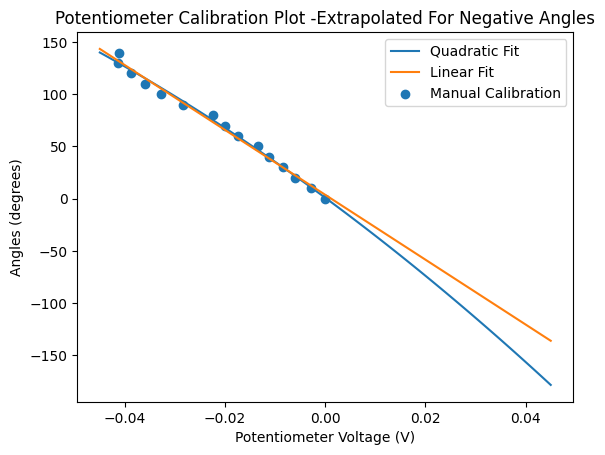

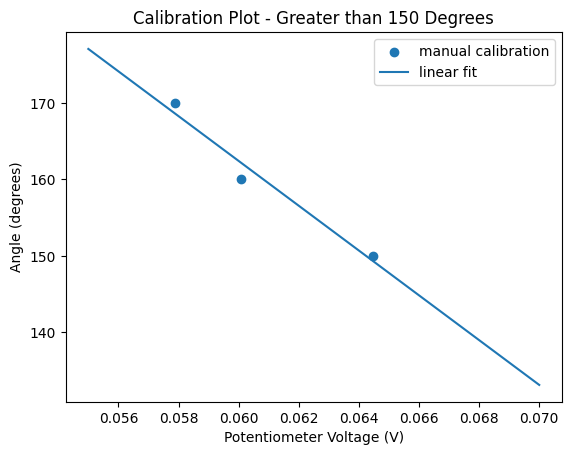

In [190]:
import pandas as pd
from statistics import mean,median,stdev
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Define a function to which data will be fit.
def theta_solution(t,a,b,c,d):
    return a*np.exp(b*t)*np.cos(c*t-d)

def linear_fit(v,m,c):
    return m*v +c

def quadratic_fit(v,a,b,c):
    return a*v**2+b*v + c

# Define a function that can read a data file.
def getData(file):
    tab1 = pd.read_csv(file,
                    index_col=None,
                    header=None,
                    names=['Time','Voltage','AveVoltage'],
                    skiprows=12,
                    )
    return tab1

#calibration data
arr = np.array([])
data = getData("data/Deg0.csv")
v_data_offset = data["Voltage"][3000]
for i in range(0,150,10):
    file_name = "data/Deg"+str(i)+".csv"
    data = getData(file_name) 
    v_data = data["Voltage"]-v_data_offset
    avg = np.mean(v_data)
    arr = np.append(arr,avg)
degrees = np.arange(0,150,10)  

linearfit = curve_fit(linear_fit,arr,degrees)
m = linearfit[0][0]
n = linearfit[0][1]
coef = [m,n]
voltage = np.linspace(-0.045,0,100)
linearfit_vals = linear_fit(voltage,m,n)
quad_fit = curve_fit(quadratic_fit,arr,degrees)
p = quad_fit[0][0]
q = quad_fit[0][1]
r = quad_fit[0][2]
quadraticfit_vals = quadratic_fit(voltage,p,q,r)

voltage = np.linspace(-0.045,0.045,100)
linearfit_vals = linear_fit(voltage,m,n)
quadraticfit_vals = quadratic_fit(voltage,p,q,r)
plt.plot(voltage,quadraticfit_vals, label="Quadratic Fit")
plt.plot(voltage,linearfit_vals, label="Linear Fit")
plt.scatter(arr, degrees, label = "Manual Calibration")
plt.xlabel("Potentiometer Voltage (V)")
plt.ylabel("Angles (degrees)")
plt.title("Potentiometer Calibration Plot -Extrapolated For Negative Angles")
plt.legend()
plt.show()

###########################################################
#Angles greater than 150 degrees
arr2 = np.array([])
for i in range(150,180,10):
    file_name = "data/Deg"+str(i)+".csv"
    data = getData(file_name) 
    v_data = data["Voltage"]-v_data_offset
    avg = np.mean(v_data)
    arr2 = np.append(arr2,avg)
degrees2 = np.arange(150,180,10)  
#linear fit specific to greater than 150
l_150 = curve_fit(linear_fit, arr2, degrees2)
m_2 = l_150[0][0]
n_2 = l_150[0][1]
coef_150 = [m_2,n_2]
volt_150 = np.linspace(0.055,0.07)
lin_150  = linear_fit(volt_150,coef_150[0],coef_150[1])
plt.scatter(arr2,degrees2, label='manual calibration')
plt.plot(volt_150,lin_150, label='linear fit')
plt.xlabel('Potentiometer Voltage (V)')
plt.ylabel('Angle (degrees)')
plt.title("Calibration Plot - Greater than 150 Degrees")
plt.legend()
plt.show()


In [191]:
def angles_data_elementwise(v_data, coef_150, coef):
    mask = (-0.045 <= v_data) & (v_data <= 0.045)
    output = np.empty_like(v_data, dtype=float)
    output[mask] = linear_fit(v_data[mask], coef[0], coef[1])
    output[~mask] = linear_fit(v_data[~mask], coef_150[0], coef_150[1])
    
    return output


def process_and_plot(start,finis,file_name):

    experiment = getData(file_name)
    v_offset = experiment["AveVoltage"][finis]
    t_offset = experiment["Time"][start]
    
    # Create data vectors
    t_data = np.array(experiment["Time"][start:finis]) - t_offset
    v_data = np.array(experiment["AveVoltage"][start:finis]) - v_offset
    

    angles_data = angles_data_elementwise(v_data, coef_150, coef)
    

    popt, _ = curve_fit(theta_solution, t_data, angles_data)
    a, b, c, d = popt
    theta_model_vals = theta_solution(t_data, a, b, c, d)
    
    
    labelstring = f"A={a:.4f},B={b:.4f},C={c:.4f},D={d:.4f}"
    titlestring = r"$\theta(t) = A e^{Bt} \cos(Ct -D)$"

    peaks, properties = find_peaks(angles_data, height=None, distance=None) 
    peak_times = np.array(t_data)[peaks]
    periods = np.diff(peak_times)
    avg_period = np.mean(periods) if periods.size > 0 else np.nan

    frequency = 1 / avg_period if avg_period > 0 else np.nan
    
    # Plot the data and the fitted model
    plt.plot(t_data, angles_data, marker='.', markersize=1, label='data')
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.plot(t_data, theta_model_vals, label=labelstring)
    plt.title(titlestring)
    plt.legend()
    plt.show()
    return np.array([a,b,c,d])

## Case 1

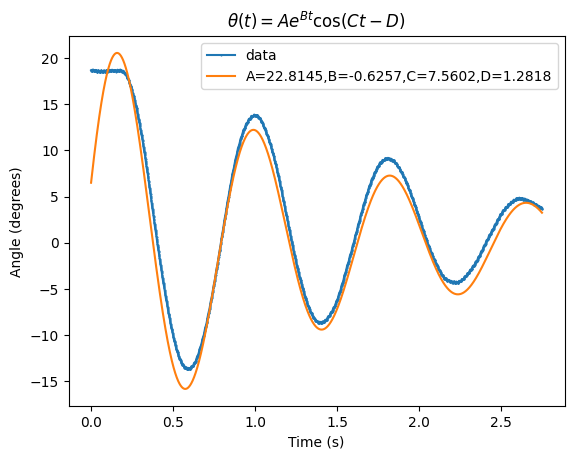

In [192]:
case_1 = process_and_plot(250,3000, 'data/Dynamic/case1.csv')

## Case 2

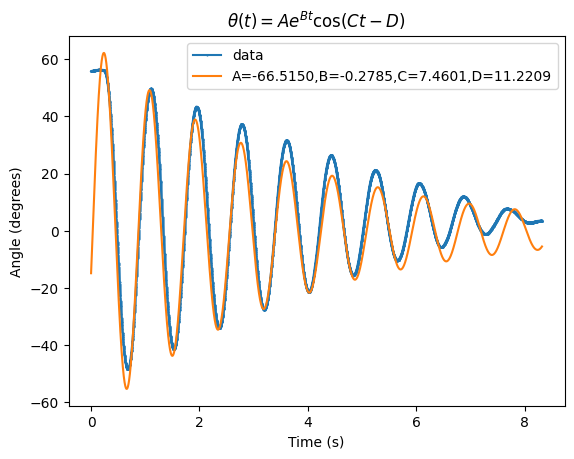

In [193]:
case_2 = process_and_plot(680,9000, 'data/Dynamic/case2.csv')

## Case 3

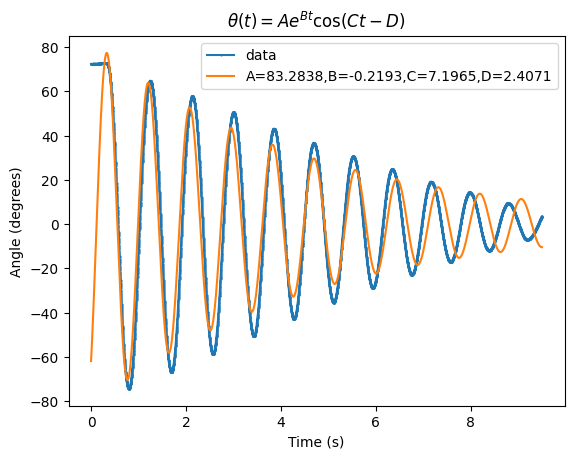

In [194]:
case_3 = process_and_plot(500,10000, 'data/Dynamic/case3.csv')

## Case 4

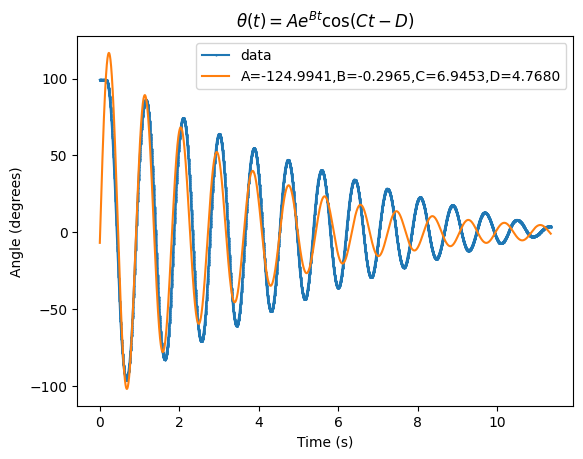

In [195]:
case_4 = process_and_plot(650,12000, 'data/Dynamic/case4.csv')

## Case 5

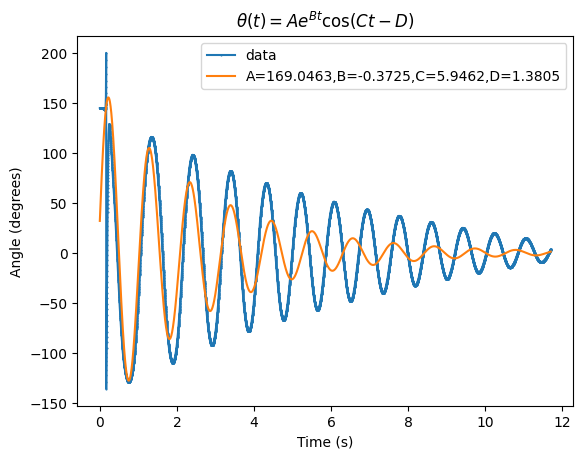

In [196]:
case_5 = process_and_plot(800,12500, 'data/Dynamic/case5.csv')

## Case 6

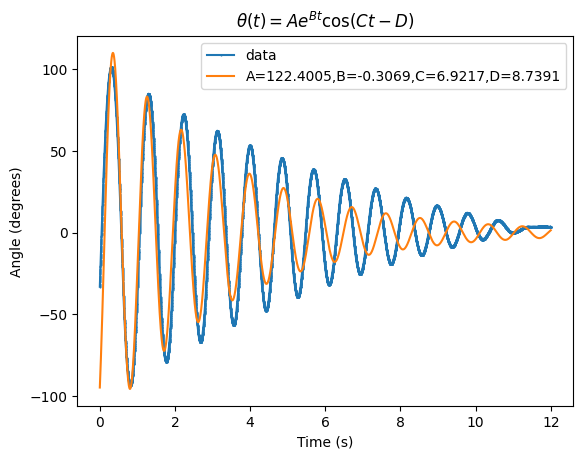

In [197]:
case_6 = process_and_plot(3000,14999, 'data/Dynamic/case6.csv')

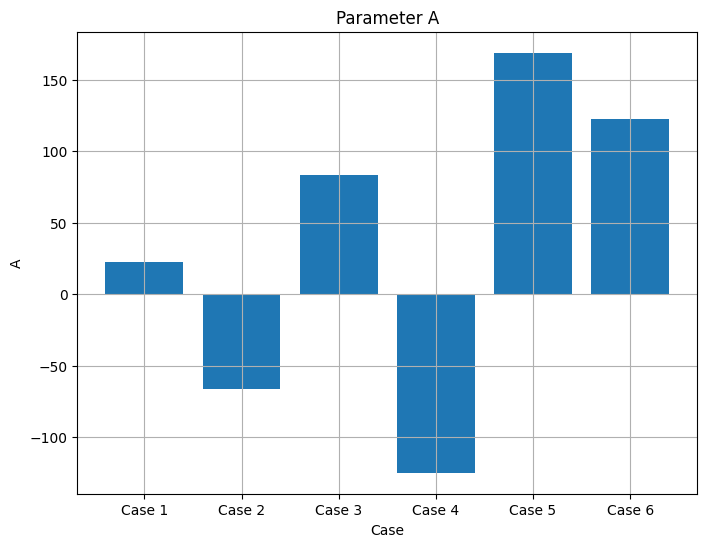

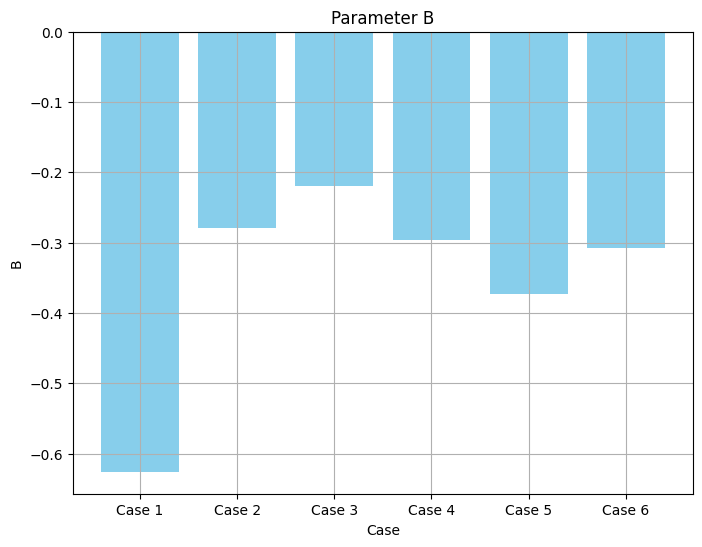

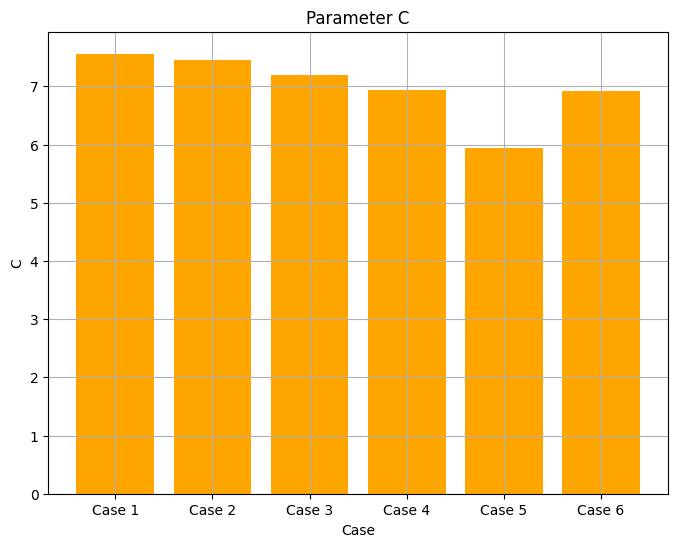

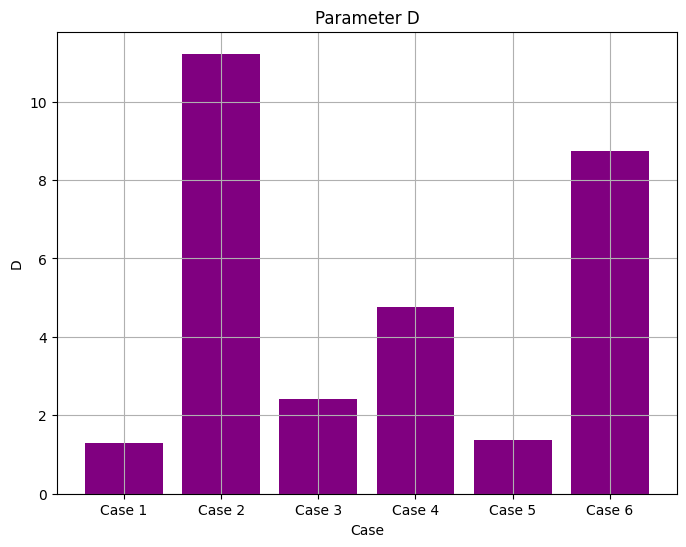

In [198]:
cases = np.vstack([case_1, case_2, case_3, case_4, case_5, case_6])

# Parameter names corresponding to indices 0,1,2,3
param_names = ['A', 'B', 'C', 'D']
n_cases = cases.shape[0]

# Create a plot for parameter A (index 0)
plt.figure(figsize=(8, 6))
plt.bar(np.arange(n_cases), cases[:, 0])
plt.title("Parameter A")
plt.xlabel("Case")
plt.ylabel("A")
plt.xticks(np.arange(n_cases), [f"Case {j+1}" for j in range(n_cases)])
plt.grid(True)
plt.show()

# Create a plot for parameter B (index 1)
plt.figure(figsize=(8, 6))
plt.bar(np.arange(n_cases), cases[:, 1], color='skyblue')
plt.title("Parameter B")
plt.xlabel("Case")
plt.ylabel("B")
plt.xticks(np.arange(n_cases), [f"Case {j+1}" for j in range(n_cases)])
plt.grid(True)
plt.show()

# Create a plot for parameter C (index 2)
plt.figure(figsize=(8, 6))
plt.bar(np.arange(n_cases), cases[:, 2], color='orange')
plt.title("Parameter C")
plt.xlabel("Case")
plt.ylabel("C")
plt.xticks(np.arange(n_cases), [f"Case {j+1}" for j in range(n_cases)])
plt.grid(True)
plt.show()

# Create a plot for parameter D (index 3)
plt.figure(figsize=(8, 6))
plt.bar(np.arange(n_cases), cases[:, 3], color='purple')
plt.title("Parameter D")
plt.xlabel("Case")
plt.ylabel("D")
plt.xticks(np.arange(n_cases), [f"Case {j+1}" for j in range(n_cases)])
plt.grid(True)
plt.show()